# Point Net - Classification

Classify objects from the shapenet dataset

In [1]:
import os
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef

from open3d.web_visualizer import draw

import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
# Supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Run this only if you don't already have the Dataset
# !wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
# !unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
# !rm shapenetcore_partanno_segmentation_benchmark_v0.zip

### Get the data

In [3]:
# General parameters
NUM_TRAIN_POINTS = 2500
NUM_TEST_POINTS = 10000
NUM_CLASSES = 16
ROOT = './data/shapenetcore_partanno_segmentation_benchmark_v0'

# model hyperparameters
GLOBAL_FEATS = 1024

BATCH_SIZE = 32

Helpers for our dataset

In [4]:
# get class - label mappings
CATEGORIES = {
    'Airplane': 0, 
    'Bag': 1, 
    'Cap': 2, 
    'Car': 3,
    'Chair': 4, 
    'Earphone': 5, 
    'Guitar': 6, 
    'Knife': 7, 
    'Lamp': 8, 
    'Laptop': 9,
    'Motorbike': 10, 
    'Mug': 11, 
    'Pistol': 12, 
    'Rocket': 13, 
    'Skateboard': 14, 
    'Table': 15}
            
# Simple point cloud coloring mapping for part segmentation
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 0, 0],
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

In [5]:
from torch.utils.data import DataLoader
from shapenet_dataset import ShapenetDataset

# train Dataset & DataLoader
train_dataset = ShapenetDataset(ROOT, npoints=NUM_TRAIN_POINTS, split='train', classification=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Validation Dataset & DataLoader
valid_dataset = ShapenetDataset(ROOT, npoints=NUM_TRAIN_POINTS, split='valid', classification=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# test Dataset & DataLoader 
test_dataset = ShapenetDataset(ROOT, npoints=NUM_TEST_POINTS, split='test', classification=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# test Dataset  (segmentation version for display)
test_sample_dataset = ShapenetDataset(ROOT, npoints=NUM_TEST_POINTS, split='test', 
                                      classification=False, normalize=False)

### Explore the training data

In [6]:
sample_dataset = ShapenetDataset(ROOT, npoints=20000, split='train', 
                                 classification=False, normalize=False)

In [7]:
import open3d

points, seg = sample_dataset[4000]

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(points)
pcd.colors = open3d.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

draw(pcd)

[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
[Open3D INFO] ICE servers: {"stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"}
FEngine (64 bits) created at 0x7f268e942010 (threading is enabled)
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.
EGL(1.5)
OpenGL(4.1)


WebVisualizer(window_uid='window_0')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.4281635358243425
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.4281635358243425
[Open3D INFO] Sending init frames to window_0.


Explore class frequencies and plot barchart

In [8]:
total_train_targets = []
for (_, targets) in train_dataloader:
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)

[000:000][107931] (stun_port.cc:96): Binding request timed out from 192.168.86.x:39591 (wlp82s0)


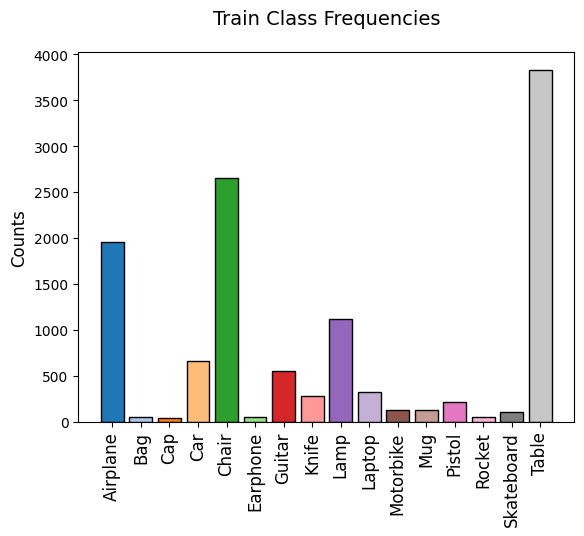

In [9]:
import matplotlib

class_bins = np.bincount(total_train_targets)

plt.bar(list(CATEGORIES.keys()), class_bins, 
             color=matplotlib.cm.tab20(np.arange(0, NUM_CLASSES)),
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Train Class Frequencies', size=14, pad=20);

In [10]:
from point_net import PointNetClassHead

points, targets = next(iter(train_dataloader))

classifier = PointNetClassHead(k=NUM_CLASSES, num_global_feats=GLOBAL_FEATS)
out, _, _ = classifier(points.transpose(2, 1))
print(f'Class output shape: {out.shape}')

Class output shape: torch.Size([32, 16])


Get DEVICE

In [11]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

### Define Loss for PointNet

For Point Net we will use the Categorical Cross Entropy loss with a regularization term that will enforce the high dimensional transform matrix to 0. We will also present the option for using the Balanced Cross Entropy loss via the 'alpha' argument which assigns a weight to each class this weights the importance of each example based on their class frequencies. We also provide the option to use the Focal loss which adds a modulating term to the Cross Entropy Loss $(1 - p_n)^\gamma$, this term forces the model to focus on hard examples (i.e. examples with low prediction probability). Some notes on the Focal Loss are given below.

#### Focal Loss Notes
The Focal Loss is a modified Cross Entropy (CE) Loss. The CE Loss for a sample $n$ is given below. 

$$ CE(s_n, y_n) = -\alpha_{y_n} log \left( \frac{exp(\mathbf{s_n})}{\sum_{c=1}^M exp(s_{n,c})} \right) \mathbf{1}_C(y_n) $$

Where $\mathbf{s_n}$ is the predicted class score vector (logits), $M$ is the number of classes, $y_n$ is the true class, $\alpha_{y_n}$ is the class weight, and $\mathbf{1}_C(y_n)$ is the [Indcator Function](https://en.wikipedia.org/wiki/Indicator_function) that tells us to only consider the prediction for the current class $y_n$. <br>
$e.g.$ if $\mathbf{s_n} = [0.02, 0.142, 0.356, 0.0012, 0.0456]$ and $y_n = 3$, then $\mathbf{s_n}  \mathbf{1}_C(y_n) = 0.0012$ (NOTE: we used zero indexing here).

We may also notice that the term inside the $log$ is the Softmax function, which along wth the indicator function, gives us the predicted class probability. We can rewrite the CE Loss in a more simple format as:
$$ CE(p_n) = -\alpha_{y_n} log(p_n)  $$
Where the $n$ subscript refers to the true class at sample $n$.

<br> 
The CE loss is typically unweighted, but if a weight is used it is reffered to as the Balanced (or Weighted) CE Loss. The weights are usually based on inverse class distribution and typically range from [0, 1]. The weights can also be set as a hyperparameter via Cross Validation.

$$ \mathbf{\alpha} = \frac{1}{\text{class counts}} $$
We may also normalize alpha so that it spreads between [0,1]
$$ \alpha = \frac{\alpha}{\max{\alpha}} $$


<br>

The Focal Loss adds an additional modulating factor to the weighted CE Loss: $ (1 - p_n)^\gamma $, where $\gamma \geq 0$ is referred to as the focusing parameter. This term has tends to 0 when the prediction probability is high, and has a larger value when the prediction probability is lower forcing the model to focus on the hard examples. It can be said that the focusing parameter smoothly adjusts the rate at which easy examples are down-weighted. We can formally express the Focal Loss as:

$$ FL(p_n) = -\alpha_{y_n} (1 - p_n)^\gamma log(p_n)  $$

<br> Summary: <br>
- The Focal Loss is a modified version of the Balanced Cross Entropy Loss
- The class weight $\alpha$ balances the importance of loss values based class distribution
- The modulating term forces the model to focus on the hard examples by downweighting the easy examples
increasing the loss of predictions with lower probability.
- The class weights $\alpha$ and focusing parameter $\gamma$ are hyperparameters that can be tuned 

<br>
Sources: <br>

- https://gombru.github.io/2018/05/23/cross_entropy_loss/ 
- https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
- https://hasty.ai/docs/mp-wiki/loss/focal-loss
- https://arxiv.org/pdf/1708.02002.pdf

In [12]:
import torch.optim as optim
from point_net_loss import PointNetLoss

EPOCHS = 15
LR = 0.0001
REG_WEIGHT = 0.001 

# use inverse class weighting
# alpha = 1 / class_bins
# alpha = (alpha/alpha.max())

# manually downweight the high frequency classes
alpha = np.ones(NUM_CLASSES)
alpha[0] = 0.5  # airplane
alpha[4] = 0.5  # chair
alpha[-1] = 0.5 # table

gamma = 2

optimizer = optim.Adam(classifier.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, 
                                              step_size_up=2000, cycle_momentum=False)
criterion = PointNetLoss(alpha=alpha, gamma=gamma, reg_weight=REG_WEIGHT).to(DEVICE)

classifier = classifier.to(DEVICE)

We want to be sure we are not misclassifying or only focusing on easy or abundant examples. So we use the Matthews Correlation Coefficient to measure our models performance.

In [13]:
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=NUM_CLASSES).to(DEVICE)

### Begin Training Model

First define a helper function to train, validate, and test

In [14]:
def train_test(classifier, dataloader, num_batch, epoch, split='train'):
    ''' Function to train or test the model '''
    _loss = []
    _accuracy = []
    _mcc = []

    # return total targets and predictions for test case only
    total_test_targets = []
    total_test_preds = [] 
    for i, (points, targets) in enumerate(dataloader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)
        
        # zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _, A = classifier(points)

        # get loss and perform backprop
        loss = criterion(preds, targets, A) 

        if split == 'train':
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        # get class predictions
        pred_choice = torch.softmax(preds, dim=1).argmax(dim=1) 
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct.item()/float(BATCH_SIZE)
        mcc = mcc_metric(preds, targets)

        # update epoch loss and accuracy
        _loss.append(loss.item())
        _accuracy.append(accuracy)
        _mcc.append(mcc.item())

        # add to total targets/preds
        if split == 'test':
            total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
            total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 100 == 0:
            print(f'\t [{epoch}: {i}/{num_batch}] ' \
                  + f'{split} loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} mcc: {mcc:.4f}')
        
    epoch_loss = np.mean(_loss)
    epoch_accuracy = np.mean(_accuracy)
    epoch_mcc = np.mean(_mcc)

    print(f'Epoch: {epoch} - {split} Loss: {epoch_loss:.4f} ' \
          + f'- {split} Accuracy: {epoch_accuracy:.4f} ' \
          + f'- {split} MCC: {epoch_mcc:.4f}')

    if split == 'test':
        return epoch_loss, epoch_accuracy, epoch_mcc, total_test_targets, total_test_preds
    else: 
        return epoch_loss, epoch_accuracy, epoch_mcc

In [ ]:
# stuff for training
num_train_batch = int(np.ceil(len(train_dataset)/BATCH_SIZE))
num_valid_batch = int(np.ceil(len(valid_dataset)/BATCH_SIZE))

# store best validation mcc above 0.
best_mcc = 0.

# lists to store metrics (loss, accuracy, mcc)
train_metrics = []
valid_metrics = []

# TRAIN ON EPOCHS
for epoch in range(1, EPOCHS):

    ## train loop
    classifier = classifier.train()
    
    # train
    _train_metrics = train_test(classifier, train_dataloader, 
                                num_train_batch, epoch, 
                                split='train')
    train_metrics.append(_train_metrics)
        

    # pause to cool down
    time.sleep(4)

    ## validation loop
    with torch.no_grad():

        # place model in evaluation mode
        classifier = classifier.eval()

        # validate
        _valid_metrics = train_test(classifier, valid_dataloader, 
                                    num_valid_batch, epoch, 
                                    split='valid')
        valid_metrics.append(_valid_metrics)

        # pause to cool down
        time.sleep(4)

    # save model if necessary
    if valid_metrics[-1][-1] >= best_mcc:
        best_mcc = valid_metrics[-1][-1]
        torch.save(classifier.state_dict(), 'trained_models/cls_focal_clr_2/cls_model_%d.pth' % epoch)

#### Plot training metrics

In [ ]:
metric_names = ['loss', 'accuracy', 'mcc']
_, ax = plt.subplots(len(metric_names), 1, figsize=(8, 6))

for i, m in enumerate(metric_names):
    ax[i].set_title(m)
    ax[i].plot(train_metrics[:, i], label='train')
    ax[i].plot(valid_metrics[:, i], label='valid')
    ax[i].legend()

plt.subplots_adjust(wspace=0., hspace=0.35)
plt.show()

### Test Model performance

In [17]:
MODEL_PATH = 'trained_models/cls_focal_clr_2/cls_model_10.pth'

classifier = PointNetClassHead(num_points=NUM_TEST_POINTS, num_global_feats=GLOBAL_FEATS, k=NUM_CLASSES).to(DEVICE)
classifier.load_state_dict(torch.load(MODEL_PATH))
classifier.eval();

#### Run test loop and get confusion matrix

In [18]:
num_test_batch = int(np.ceil(len(test_dataset)/BATCH_SIZE))

with torch.no_grad():
    epoch_loss, \
    epoch_accuracy, \
    epoch_mcc, \
    total_test_targets, \
    total_test_preds = train_test(classifier, test_dataloader, 
                              num_test_batch, epoch=1, 
                              split='test')

	 [1: 0/90] test loss: 0.0038 accuracy: 0.9688 mcc: 0.0000
Epoch: 1 - test Loss: 0.2398 - test Accuracy: 0.8410 - test MCC: 0.0646


In [19]:
print(f'Test Loss: {epoch_loss:.4f} ' \
      f'- Test Accuracy: {epoch_accuracy:.4f} ' \
      f'- Test MCC: {epoch_mcc:.4f}')

Test Loss: 0.2398 - Test Accuracy: 0.8410 - Test MCC: 0.0646


In [20]:
from sklearn.metrics import confusion_matrix

test_confusion = pd.DataFrame(confusion_matrix(total_test_targets, total_test_preds),
                              columns=list(CATEGORIES.keys()),
                              index=list(CATEGORIES.keys()))

test_confusion

,Airplane,Bag,Cap,Car,Chair,Earphone,Guitar,Knife,Lamp,Laptop,Motorbike,Mug,Pistol,Rocket,Skateboard,Table
Airplane,320,0,0,0,6,0,0,1,8,3,1,0,0,0,2,0
Bag,0,0,1,1,2,0,0,0,7,0,0,2,0,0,0,1
Cap,0,0,1,0,2,0,0,0,7,0,0,0,0,0,0,1
Car,0,0,2,132,4,0,0,0,0,0,0,0,0,0,0,20
Chair,1,0,0,1,677,0,1,0,1,10,0,8,0,0,1,4
Earphone,0,0,1,0,1,1,0,0,9,1,0,0,0,0,1,0
Guitar,2,0,1,0,7,2,87,0,57,2,0,0,0,0,0,1
Knife,3,0,5,2,4,2,19,19,20,0,0,1,0,0,0,5
Lamp,5,0,0,0,3,0,1,3,249,9,1,3,0,0,1,11
Laptop,0,0,0,0,0,0,0,0,0,82,0,0,0,0,0,1


In [21]:
from random import randrange

torch.cuda.empty_cache() # release GPU memory

# get random sample from test data 
random_idx = randrange(len(test_sample_dataset))
points, seg = test_sample_dataset.__getitem__(random_idx)

# normalize points
norm_points = test_sample_dataset.normalize_points(points)

with torch.no_grad():
    norm_points = norm_points.unsqueeze(0).transpose(2, 1).to(DEVICE)
    targets = targets.squeeze().to(DEVICE)

    preds, crit_idxs, _ = classifier(norm_points)
    preds = torch.softmax(preds, dim=1)
    pred_choice = preds.squeeze().argmax() 

Inspect the results

In [22]:
pred_class = list(CATEGORIES.keys())[pred_choice.cpu().numpy()]
pred_prob = preds[0, pred_choice]
print(f'The predicted class is: {pred_class}, with probability: {pred_prob}')

The predicted class is: Car, with probability: 0.9786752462387085


Visualize the probabilities

This code was inspired from: https://github.com/intel-isl/Open3D-PointNet


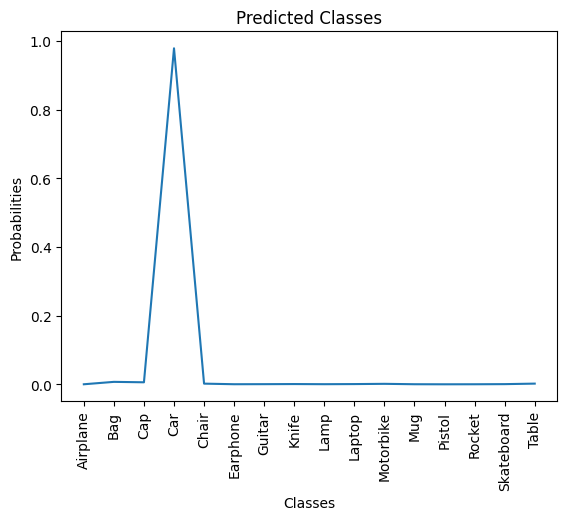

In [23]:
plt.plot(list(CATEGORIES.values()), preds.cpu().numpy()[0]);
plt.xticks(list(CATEGORIES.values()), list(CATEGORIES.keys()), rotation=90)
plt.title('Predicted Classes')
plt.xlabel('Classes')
plt.ylabel('Probabilities');

In [25]:
pcd = open3d.geometry.PointCloud()
# pcd.points = open3d.utility.Vector3dVector(norm_points[0, :, :].cpu().numpy().T)
pcd.points = open3d.utility.Vector3dVector(points.cpu().numpy())
pcd.colors = open3d.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

# open3d.visualization.draw_plotly([pcd])
draw(pcd, point_size=5)

[Open3D INFO] Window window_1 created.


WebVisualizer(window_uid='window_1')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.9488885239011831
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.9488885239011831
[Open3D INFO] Sending init frames to window_1.


### Inspecting the critical sets

The critical sets are the points that make up the basic underlying structure of the point cloud. Now we will see how well the model has learned these.

See draw_plotly() source here: https://github.com/isl-org/Open3D/blob/master/python/open3d/visualization/draw_plotly.py

In [29]:
critical_points = points[crit_idxs.cpu().squeeze(), :]
critical_point_colors = read_pointnet_colors(seg.numpy())[crit_idxs.cpu().squeeze(), :]

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(critical_points)
pcd.colors = open3d.utility.Vector3dVector(critical_point_colors)

# o3.visualization.draw_plotly([pcd])
draw(pcd, point_size=5) # does not work in Colab

[Open3D INFO] Window window_2 created.


WebVisualizer(window_uid='window_2')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.49906480261936714
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.49906480261936714
[Open3D INFO] Sending init frames to window_2.


[2866:235][107931] (stun_port.cc:96): Binding request timed out from 192.168.86.x:56955 (wlp82s0)
